In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

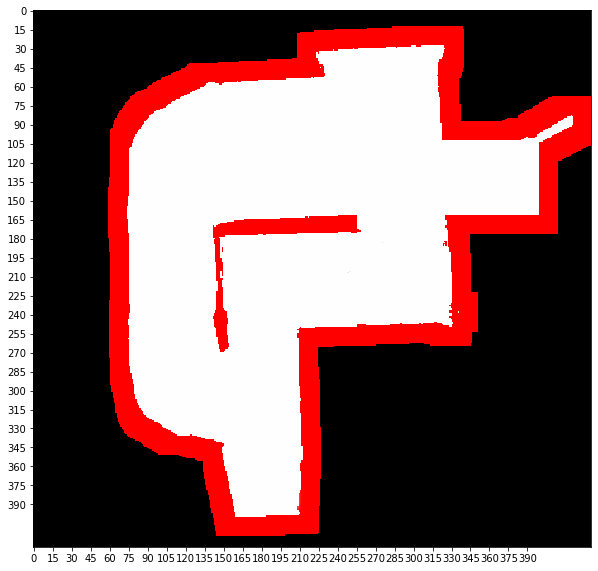

In [23]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
img=cv2.imread('final.pgm')
w,h,p = img.shape
ran=15
import copy
img_raw = copy.deepcopy(img)
for i in range(w):
    for j in range(h):
        temp = img_raw[i-1:i+1,j-1:j+1,0]
        if np.any(temp==0) and np.any(temp==254):
            img[i-ran:i+ran,j-ran:j+ran,0]=255 
plt.figure(figsize=(10, 10))
plt.xticks(np.arange(0, 400, 15))
plt.yticks(np.arange(0, 400, 15))

plt.imshow(img,cmap='gray')
# print(img)


In [3]:
# print(img[165,180,:])

In [4]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
def fit_spline(points,plot,im):
    x,y = points[:,0],points[:,1]
    # append the starting x,y coordinates
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]

    # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
    # is needed in order to force the spline fit to pass through all the input points.
    tck, u = interpolate.splprep([x, y], s=30, per=True)

    # evaluate the spline fits for 1000 evenly spaced distance values
    xi,yi = interpolate.splev(np.linspace(0, 1, 300), tck) #1000
    fitted_points = np.hstack((np.asarray(xi).reshape(-1,1),np.asarray(yi).reshape(-1,1)))
    if plot:
        plt.figure()
        plt.imshow(im,cmap='gray')
        # plot the result
        plt.plot(xi, yi, 'ob')
        
    return fitted_points

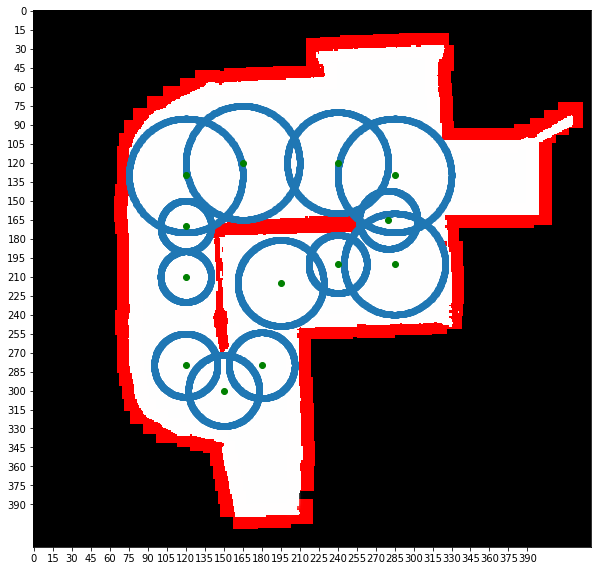

In [5]:
x = [120,120,120, 120, 165, 240, 285,280,285,240, 195,180,150]
y = [280,210,170,130, 120, 120, 130, 165,200,200,215, 280,300]
v = [5]*len(x)
v = np.asarray(v).reshape(-1,1)
ori = []
points=np.hstack((np.asarray(x).reshape(-1,1),np.asarray(y).reshape(-1,1)))
plt.figure(figsize=(10, 10))
plt.xticks(np.arange(0, 400, 15))
plt.yticks(np.arange(0, 400, 15))
plt.plot(points[:,0],points[:,1],'og')
plt.imshow(img,cmap='gray')




# import matplotlib
# a = matplotlib.patches.Circle(xy = (x[0],y[0]),radius = 5)
# print(type(pts))
# plt.plot(a)
# plt.contour(pts)
# r = 30
thetas = np.deg2rad(np.arange(0,360,1))
axs=[]
ays=[]
r = [25,20,20,45,45,40,45,23,40,23,34,26,28]
for i in range(len(x)):
    xx = x[i]
    yy = y[i]
    rr = r[i]
# xx = x[0]
# yy=[y[0]]
    for theta in thetas:
        ax = xx + rr*np.cos(theta)
        ay = yy + rr*np.sin(theta)
        axs.append(ax)
        ays.append(ay)
    # print(axs)
plt.scatter(axs,ays)
# plt.plot(axs,ays)
# plt.show()
import copy
x_raw = copy.deepcopy(x)
y_raw = copy.deepcopy(y)
r_raw = copy.deepcopy(r)
thetas_raw = copy.deepcopy(thetas)

In [6]:
from scipy.interpolate import UnivariateSpline
import numpy as np
def curvature_splines(points, error=0.1):
    x,y = points[:,0],points[:,1]
    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = abs(xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 1.5)
#     curvature[curvature<0]=0
    return curvature

def vel_profile(curv,points,plot=False):
#     max_vel,min_vel=5,1
    velocity=np.empty_like(curv)
    velocity = -90*curv + 5
    velocity[velocity<=0.5] = 0.5
    if plot:
        t=range(0,len(curv))
        # plt.plot(t,curv)
        fig, (ax1, ax2,ax3) = plt.subplots(3,1)
        fig.suptitle('Vertically stacked subplots')
        fig.set_figheight(10)
        # plt.figure(figsize=(20,10))
        ax1.plot(t, curv,'o')
        ax1.set_title('curvature')
        ax1.set_ylabel('curvature(1/m)')
        ax2.plot(t,points[:,0],'o')
        ax2.set_title('x')
        ax2.set_ylabel('position of x(pixel)')
        ax3.plot(t,velocity,'o')
        ax3.set_title('velocity')
        ax3.set_ylabel('velocity (m/s)')
    return velocity
def calculate_time(points,velocity):
    distance = np.sqrt(np.sum((np.diff(points,axis=0))**2,axis=1))
#     v = velocity[:-1]+0.5*np.abs(np.diff(velocity))
    time = np.sum(distance/v)
#     print("time:",time)
    return time

def real2pixel(ps):
    px,py=ps[:,0],ps[:,1]   
    w,h=424,441
    r=20.0
    dx=11.250755*r
    dy=w-10.439799*r
    qx = px*r + dx
    qy = py*(-r) + dy
    qx=qx.reshape(-1,1)
    qy=qy.reshape(-1,1)
    return np.hstack((qx,qy))
def pixel2real(qx,qy):
#     qx,qy=qs[:,0],qs[:,1]
    w,h=424,441
    r=20.0
    dx=11.250755*r
    dy=w-10.439799*r
    px=(qx-dx)/r
    py = (qy-dy)/(-r)
    px = px.reshape(-1,1)
    py = py.reshape(-1,1)
#     return np.hstack((px,py))
    return px,py

In [7]:
import pdb
epochs = 100
final_means=[]
final_covs=[]
final_samples=[]
final_times=[]
final_radius=[]
final_angles=[]
final_curvatures=[]
final_velocities=[]
flag = 0
for epoch in range(epochs):
    print("epoch:",epoch)
#     iterations = 1000 #num of points per sampling
    iterations = 500 #num of points per sampling
    new_samples = []
    velocities = []
    times = []
    distances = []
    radius = []
    angles = []
    curvatures = []
    for ite in range(iterations):
        # create new sample
        xs = []
        ys = []
        ths = []
        rs=[]
        
#  uniformly sample
        if flag==0:
            for i in range(len(x_raw)):
                xx,yy = x_raw[i],y_raw[i]
                rr = r_raw[i]
                rand_th= thetas_raw[np.random.randint(low=0,high=360)]
                rand_r =  np.random.rand(1)* rr 
                x_ = xx + rand_r*np.cos(rand_th)
                y_ = yy + rand_r*np.sin(rand_th)
                xs.append(x_)
                ys.append(y_)
                rs.append(rand_r)
                ths.append(rand_th)
        else:
#             print(len(means))
            for i in range(len(means)):
                mean = means[i]
                cov = covs[i]
                xx,yy = x_raw[i],y_raw[i]
                keep=True
                while keep:
                    temp = np.random.multivariate_normal(mean, cov,1)
                    rand_r,rand_th = temp[0,0],temp[0,1]
                    x_ = xx + rand_r*np.cos(rand_th)
                    y_ = yy + rand_r*np.sin(rand_th)
#                     check collision
                    if img[int(y_),int(x_),1]==0:
                        keep = True
                    else:
                        keep = False
                    
                xs.append(x_)
                ys.append(y_)
                rs.append(rand_r)
                ths.append(rand_th)
#         print('ite',ite)
#         plt.figure()
#         plt.imshow(img)
#         plt.plot(xs,ys)
# concatenate x and y
        new_sample = np.hstack((np.asarray(xs).reshape(-1,1),np.asarray(ys).reshape(-1,1)))
    
        fitted_sample = fit_spline(new_sample,0,img)

        # calculate curvature
        import copy
        sample = fitted_sample[:-1,:]
        curv = curvature_splines(sample, error=1e-10)
        v = vel_profile(curv,sample,plot=False)
        v_new = copy.deepcopy(v)
        
#  update v
#         l = len(v_new)
#         for i in range(l):
#             v_new[i] = (v[(i+1)%l]+v[(i+2)%l]+v[(i+3)%l]+v[(i+4)%l]) /4


# plot profiles
    #     t=range(0,len(curv))
    #     # plt.plot(t,curv)
    #     fig, (ax1, ax2,ax3) = plt.subplots(3,1)
    #     fig.suptitle('Vertically stacked subplots')
    #     fig.set_figheight(10)
    #     # plt.figure(figsize=(20,10))
    #     ax1.plot(t, curv,'o')
    #     ax1.set_title('curvature')
    #     ax1.set_ylabel('curvature(1/m)')
    #     ax2.plot(t,sample[:,0],'o')
    #     ax2.set_title('x')
    #     ax2.set_ylabel('position of x(pixel)')
    #     ax3.plot(t,v_new,'o')
    #     ax3.set_title('velocity')
    #     ax3.set_ylabel('velocity (m/s)')


        distance = np.sqrt(np.sum((np.diff(np.vstack((sample,sample[0,:].reshape(1,2))),axis=0))**2,axis=1))
        time = sum(distance/20 /v_new)
    #     plt.plot(t,distance,'r')
        # print(v_new.shape,distance.shape)
    #     time = distance/20 /v_new
    #     plt.figure()
    #     plt.plot(t,time)
        # print(np.min(curv))
        # print(curv)
        # print(v_new)
    #     print(time)

        new_samples.append(sample)
        distances.append(distance)
        times.append(time)
        velocities.append(v_new)
        radius.append(rs)
        angles.append(ths)
        curvatures.append(curv)
        
    new_samples = np.asarray(new_samples)
    distances = np.asarray(distances)
    times = np.asarray(times)
    velocities = np.asarray(velocities)
    curvatures = np.asarray(curvatures)
    radius = np.squeeze(np.asarray(radius))
    angles = np.asarray(angles)
#     print(new_samples.shape,distances.shape, times.shape,velocities.shape,radius.shape,angles.shape,curvatures.shape)
#     sort best examples
#     k=100
    k=50
    best_ids = np.argsort(times)[:k]
    best_samples = new_samples[best_ids]
    best_times = times[best_ids]
    best_curvatures = curvatures[best_ids]
    best_velocities = velocities[best_ids]
    best_radius = radius[best_ids]
    best_angles = angles[best_ids] 
    
    
    n1,n2 = best_radius.shape
    means=[]
    covs=[]
    print(n1,n2)
    for j in range(n2):
        single_radius = best_radius[:,j].reshape(n1,1)
        single_angle = best_angles[:,j].reshape(n1,1)
        best  = np.hstack((single_radius,single_angle))
        mean = np.mean(best,axis=0)
        cov = np.cov(best.T)
        means.append(mean)
        covs.append(cov)
#         pdb.set_trace()
#         print(mean.shape)
    flag=1
    
    
    final_means.append(means)
    final_covs.append(covs)
    final_samples.append(best_samples)
    final_times.append(best_times)
    final_curvatures.append(best_curvatures)
    final_velocities.append(best_velocities)
    final_radius.append(best_radius)
    final_angles.append(best_angles)

epoch: 0


/home/lance/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


50 13
epoch: 1
50 13
epoch: 2
50 13
epoch: 3
50 13
epoch: 4
50 13
epoch: 5
50 13
epoch: 6
50 13
epoch: 7
50 13
epoch: 8
50 13
epoch: 9
50 13
epoch: 10
50 13
epoch: 11
50 13
epoch: 12
50 13
epoch: 13
50 13
epoch: 14
50 13
epoch: 15
50 13
epoch: 16
50 13
epoch: 17
50 13
epoch: 18
50 13
epoch: 19
50 13
epoch: 20
50 13
epoch: 21
50 13
epoch: 22
50 13
epoch: 23
50 13
epoch: 24
50 13
epoch: 25
50 13
epoch: 26
50 13
epoch: 27
50 13
epoch: 28
50 13
epoch: 29
50 13
epoch: 30
50 13
epoch: 31
50 13
epoch: 32
50 13
epoch: 33
50 13
epoch: 34
50 13
epoch: 35
50 13
epoch: 36
50 13
epoch: 37
50 13
epoch: 38
50 13
epoch: 39
50 13
epoch: 40
50 13
epoch: 41
50 13
epoch: 42
50 13
epoch: 43
50 13
epoch: 44
50 13
epoch: 45
50 13
epoch: 46
50 13
epoch: 47
50 13
epoch: 48
50 13
epoch: 49
50 13
epoch: 50
50 13
epoch: 51
50 13
epoch: 52
50 13
epoch: 53
50 13
epoch: 54
50 13
epoch: 55
50 13
epoch: 56
50 13
epoch: 57
50 13
epoch: 58
50 13
epoch: 59
50 13
epoch: 60
50 13
epoch: 61
50 13
epoch: 62
50 13
epoch: 63
5

In [13]:
# print(len(final_means[0]))
final_means=np.asarray(final_means)
final_covs=np.asarray(final_covs)
print(final_means.shape,final_covs.shape)
# print(final_means)

(100, 13, 2) (100, 13, 2, 2)


In [9]:
# final_samples[0]

In [10]:
# k=50
# # print(np.sort(times)[:50])
# best_ids = np.argsort(times)[:k]
# for ind in best_ids[0:10]:
# #     print('id:',ind)
# #     print('time:',times[id])
#     plt.figure()
#     plt.imshow(img,cmap='gray')
#     plt.plot(new_samples[ind,:,0],new_samples[ind,:,1])
#     v = velocities[ind]
#     curv = curvatures[ind]
#     t = range(len(v))
#     plt.figure()
#     plt.plot(t,curv)
#     plt.figure()
#     plt.plot(t,v,'r')

Text(0, 0.5, 'Norm of Covariance')

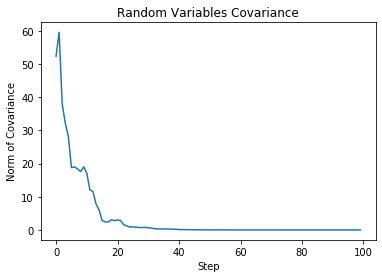

In [42]:
from numpy import linalg as LA
data = []
for i in range(len(final_times)):
    data.append(LA.norm(final_covs[i][0])) 
    
plt.figure()
t = range(len(data))
plt.plot(t,data)
plt.title("Random Variables Covariance")
plt.xlabel("Step")
plt.ylabel("Norm of Covariance") 


In [45]:
# print(times[best_ids[:3]])
for i in range(len(final_times)):
    print(final_times[i][0])


9.817338319781028
9.505557159880544
9.267008419417229
8.288079839738653
8.490471971394385
7.883758440640198
7.415595017019415
7.527780262832189
7.355351487965401
7.349589770000536
7.149575289189096
7.081265432773436
6.998036050311627
6.9575490121483305
6.867747636101053
6.848835026405192
6.83911884026486
6.785116662162956
6.7219895258053315
6.687289967178409
6.709872026362894
6.6649476592367725
6.671833774707309
6.670826062774294
6.651168189065493
6.633500380196764
6.62237696927501
6.607775460387388
6.577073555004058
6.558257573625579
6.533780781471049
6.5090207660157535
6.480620839432054
6.475937128990358
6.459932628415312
6.454341915424264
6.438432295487811
6.435014105360008
6.425164409794645
6.415814048391065
6.411545250697483
6.401766063686116
6.397003974987116
6.390908059984485
6.387706302863388
6.3808817713555825
6.377671940596919
6.373925018610972
6.3724659498163
6.369483421381726
6.366587335373388
6.362761646269985
6.360768225640445
6.357625643963356
6.356902166517324
6.3546118

/home/lance/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


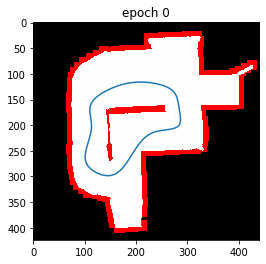

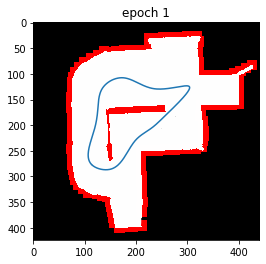

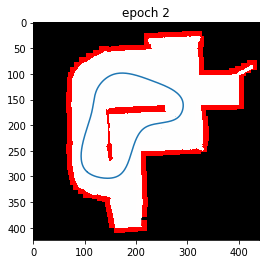

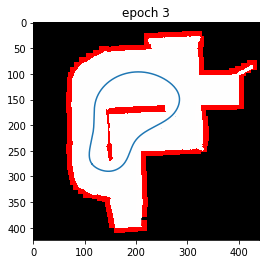

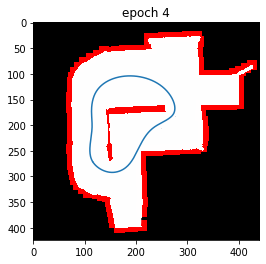

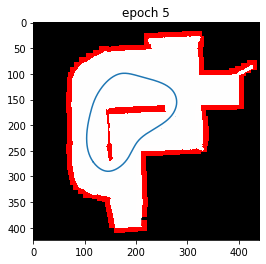

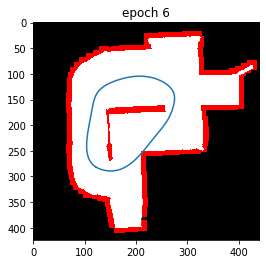

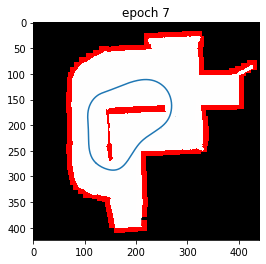

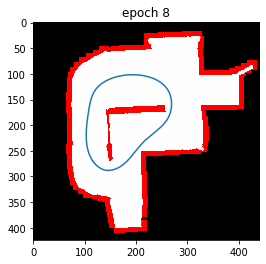

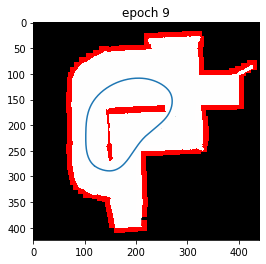

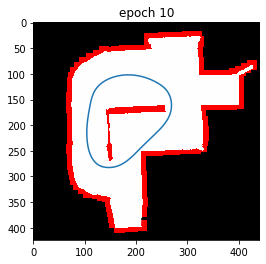

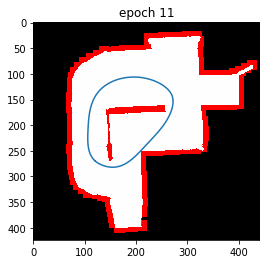

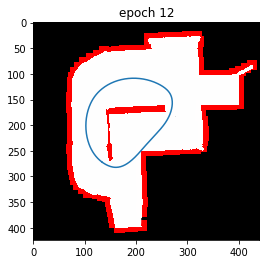

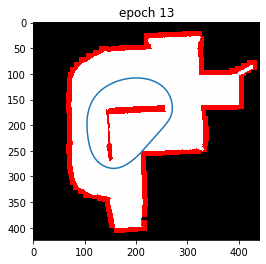

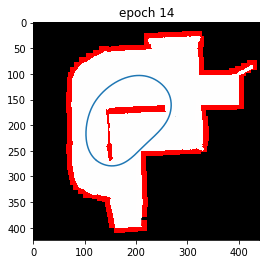

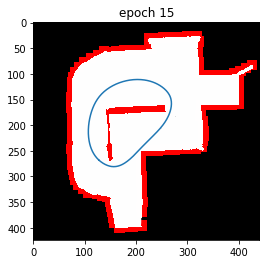

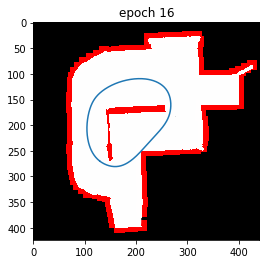

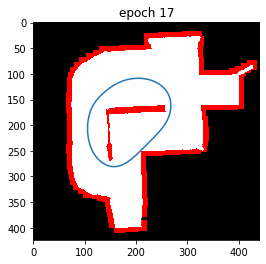

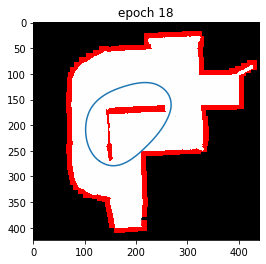

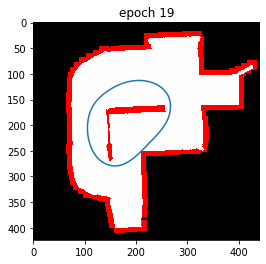

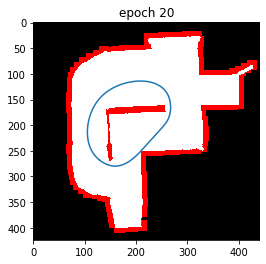

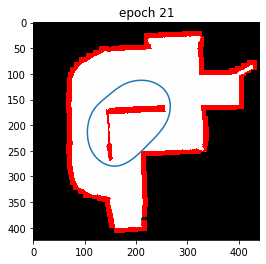

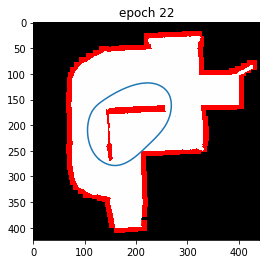

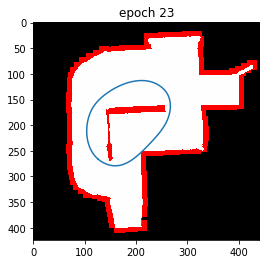

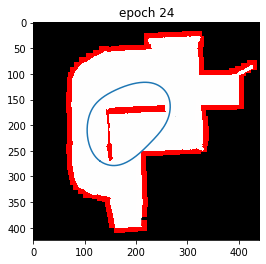

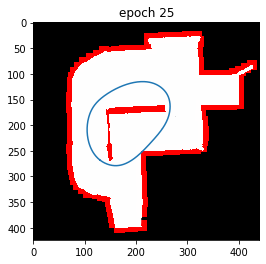

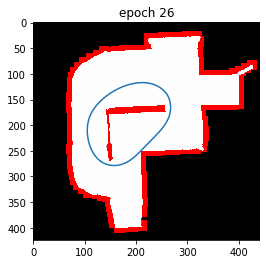

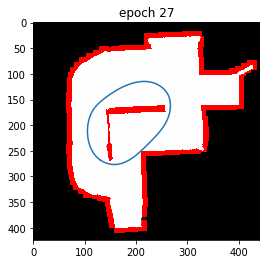

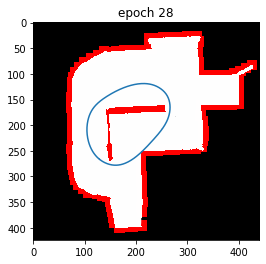

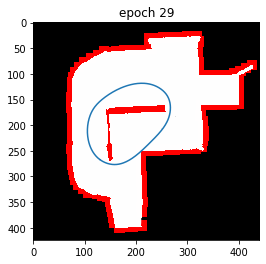

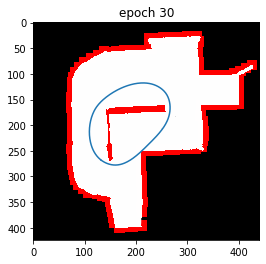

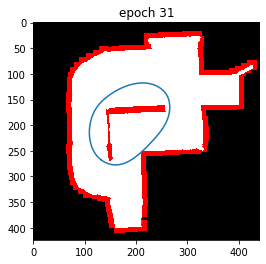

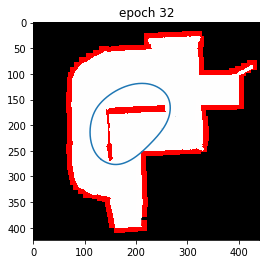

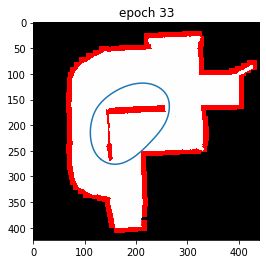

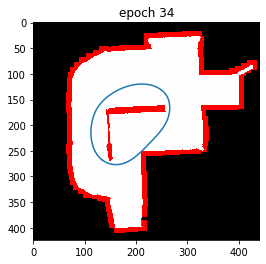

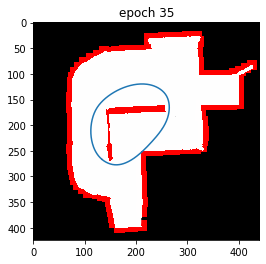

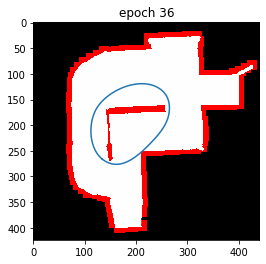

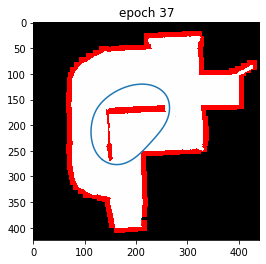

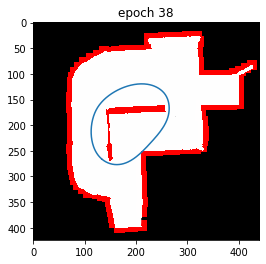

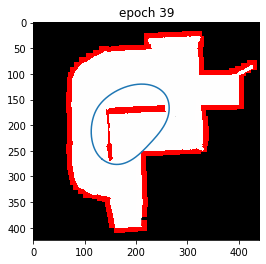

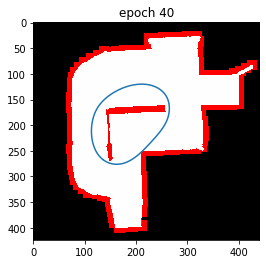

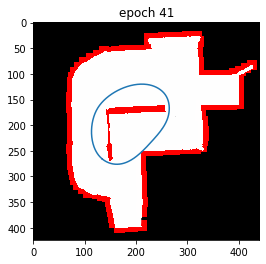

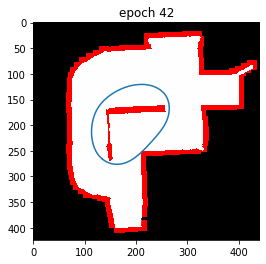

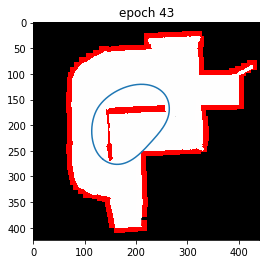

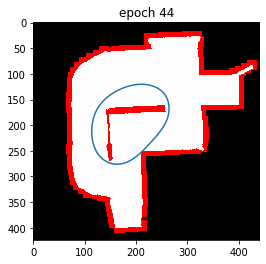

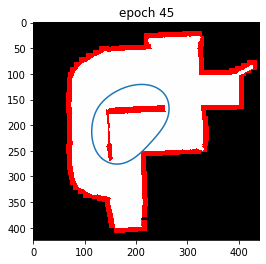

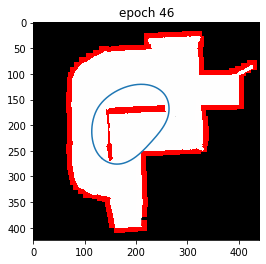

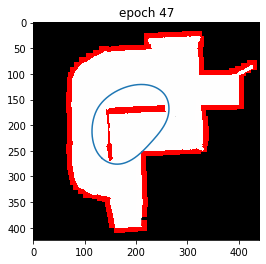

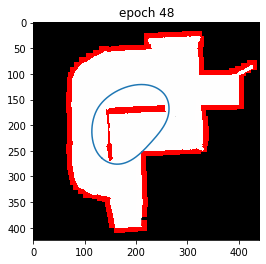

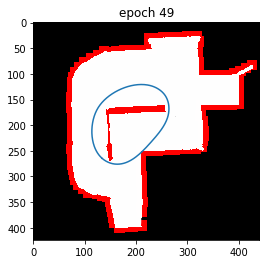

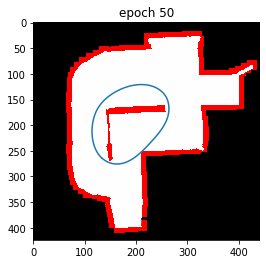

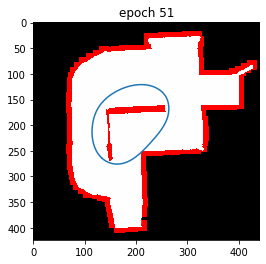

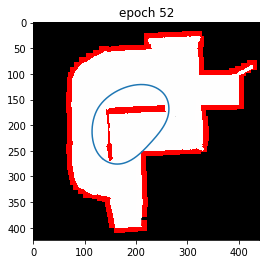

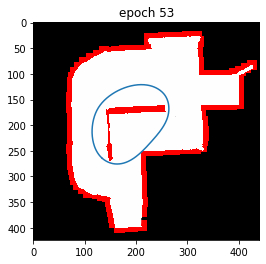

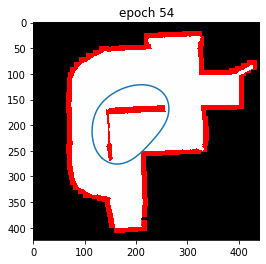

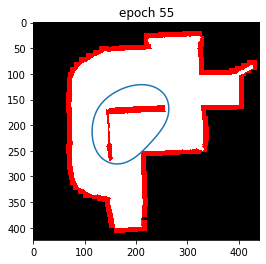

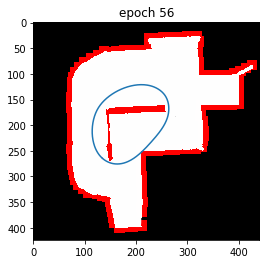

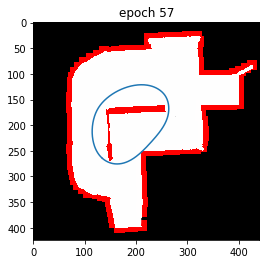

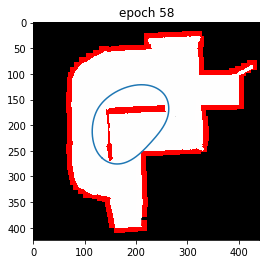

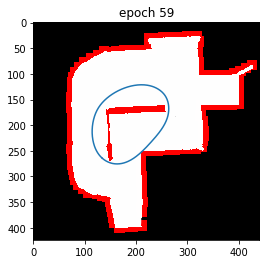

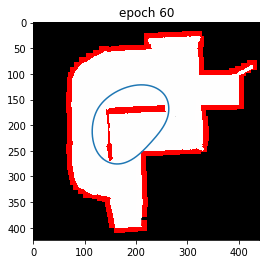

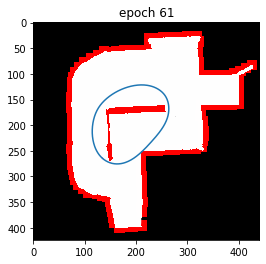

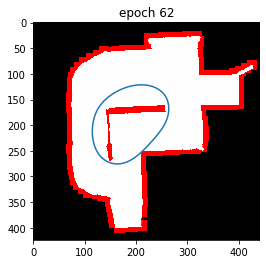

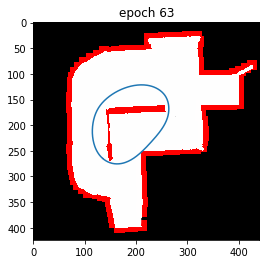

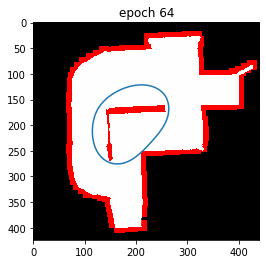

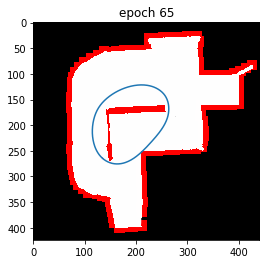

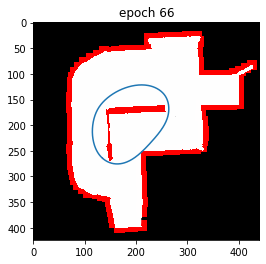

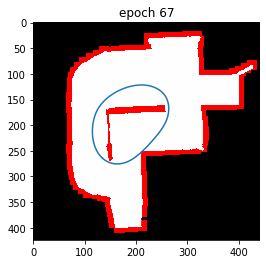

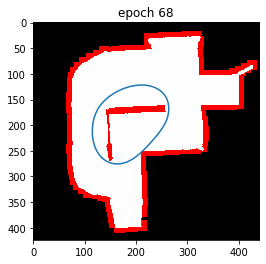

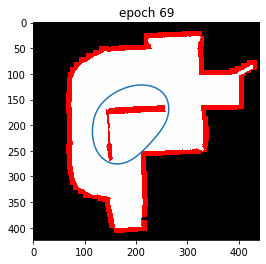

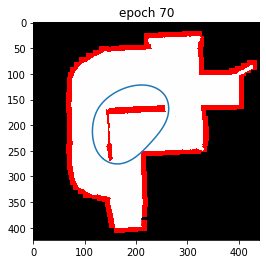

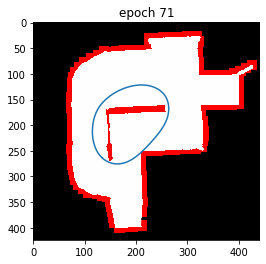

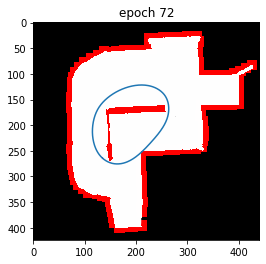

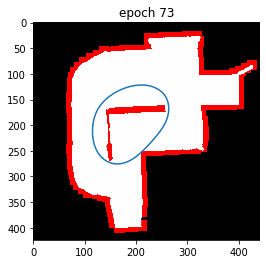

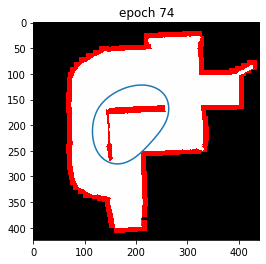

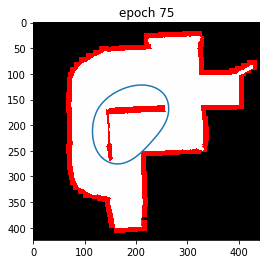

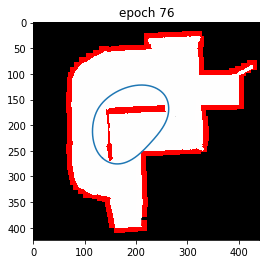

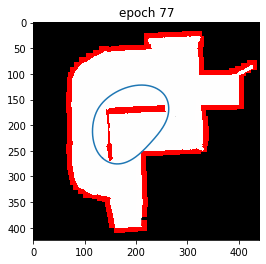

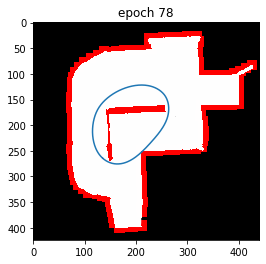

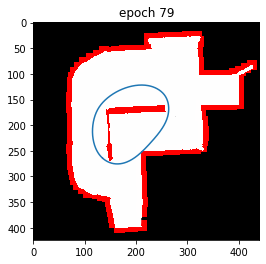

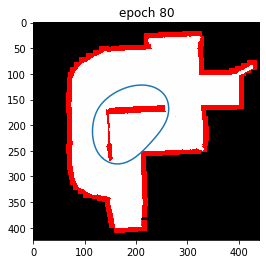

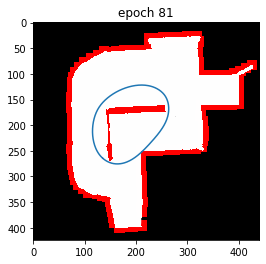

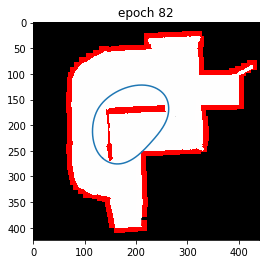

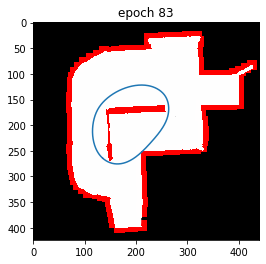

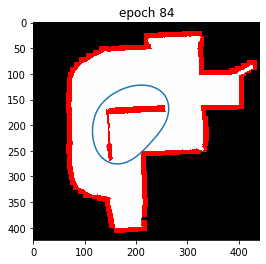

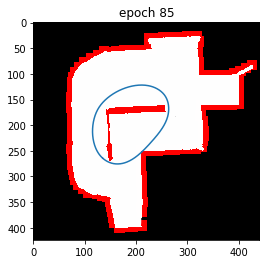

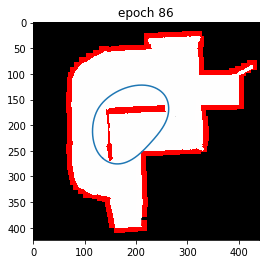

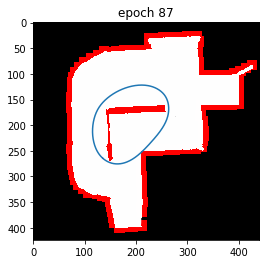

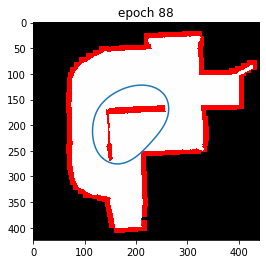

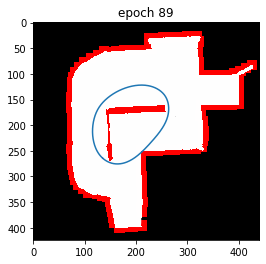

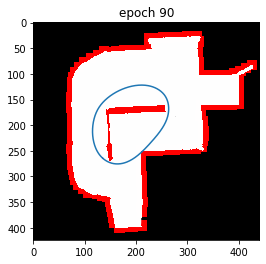

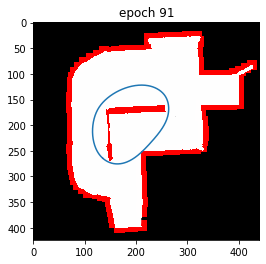

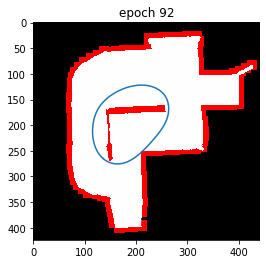

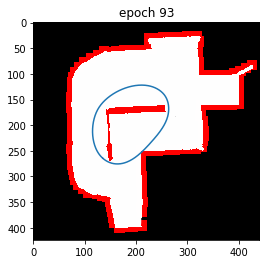

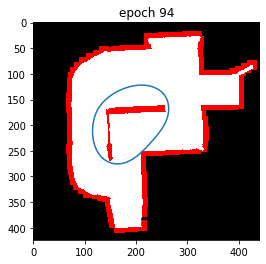

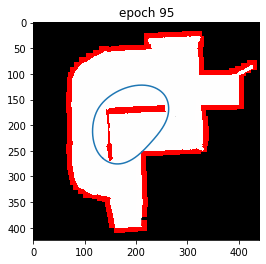

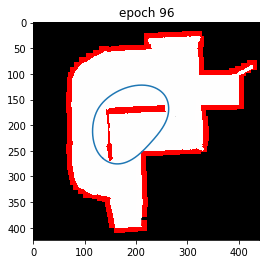

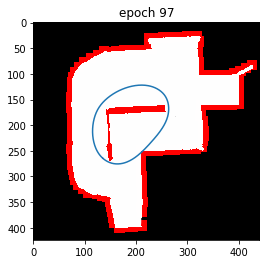

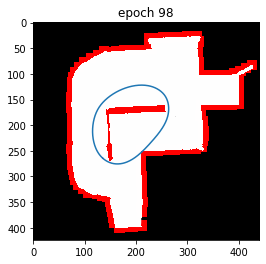

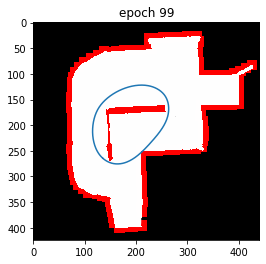

In [16]:
for i in range(100):
    plt.figure()
    plt.title(f"epoch {i}")
    plt.imshow(img)
    plt.plot(final_samples[i][0][:,0],final_samples[i][0][:,1])
    plt.savefig(f'./plots/{i}.png')

In [ ]:
for i in range(100):
    plt.figure()
    plt.title(f"epoch {i}")
    plt.imshow(img)
    plt.plot(final_velocitie[i][0][:,0],final_samples[i][0][:,1])
#     plt.savefig(f'./plots/{i}.png')

In [25]:
final_velocities[0].shape

(50, 299)

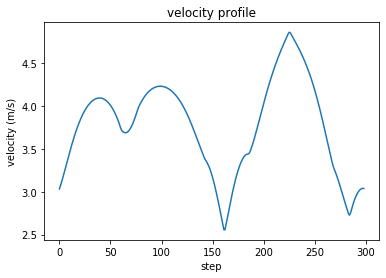

In [35]:
for i in range(98,99):
    plt.figure()
#     plt.title(f"epoch {i}")
#     plt.imshow(img)
    v = final_velocities[i][0]
#     curv = final_curvatures[i][0]
    t = range(len(v))
#     plt.plot(t,curv)
    plt.plot(t,v)
    
    plt.title("velocity profile")
    plt.xlabel("step")
    plt.ylabel("velocity (m/s)")
    
    
#     plt.savefig(f'./plots/{i}.png')

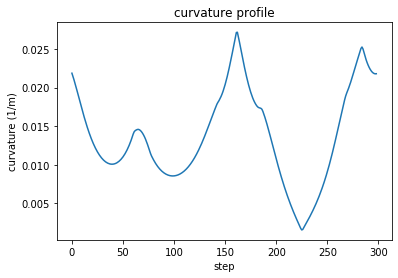

In [37]:
for i in range(98,99):
    plt.figure()
    curv = final_curvatures[i][0]
    t = range(len(v))
    plt.plot(t,curv)
    plt.title("curvature profile")
    plt.xlabel("step")
    plt.ylabel("curvature (1/m)")
    